# Non-parametric partial correlations

In [239]:
import numpy as np
from matplotlib import pyplot as pl
import seaborn as sn
import scipy.stats as stats
sn.set_style('ticks')
%matplotlib inline
from statsmodels.stats.weightstats import DescrStatsW

Let's generate some data non-linearly relating data

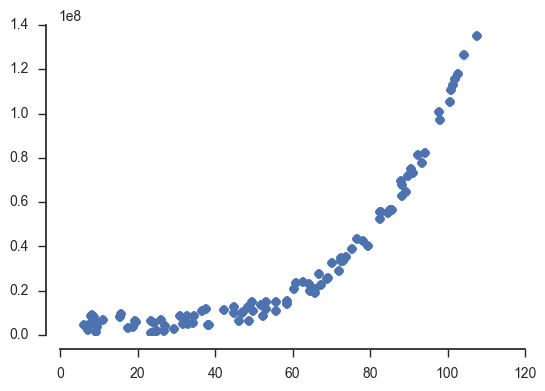

In [240]:
x = np.linspace(0,100,100)+np.random.rand(100)*10
y = x**4+np.random.rand(100)*1e7
plot(x,y,'o')
sn.despine(offset=10)

Let's compute the spearman and pearson correlations

In [241]:
print 'spearman rho: %.4f'%(stats.spearmanr(x,y)[0])
print 'pearson r: %.4f'%(stats.pearsonr(x,y)[0])


spearman rho: 0.9447
pearson r: 0.8666


Spearman's rho is higher as the relationship between x and y is not linear. Let's see if the pearson of the ranks gives the same result as spearman of original values. To calculate ranks, you can perform 2 argsorts. The first gives you the indices that would sort the array, the second gives the indices to the original data values. 

In [242]:
rank_x = np.argsort(np.argsort(x))
rank_y = np.argsort(np.argsort(y))
# print rank_y
print 'spearman rho: %.4f'%(stats.spearmanr(x,y)[0])
print 'pearson r of ranks: %.4f'%(stats.pearsonr(rank_x,rank_y)[0])

spearman rho: 0.9447
pearson r of ranks: 0.9447


Now let's use this to calculate weighted spearman correlations. Now, the values 

In [243]:
weights = np.random.rand(100)
ds = DescrStatsW(data=np.vstack([rank_x,rank_y]).T,weights=weights)
print 'weighted pearson r of ranks: %.4f'%(ds.corrcoef[0,1])

weighted pearson r of ranks: 0.9409


And let's use the spearman of ranks to calculate partial correlations. Partial correlations can be computed in multiple ways. Let's consider 2 methods: (1) correlating residuals, and (2) inverting the correlation matrix


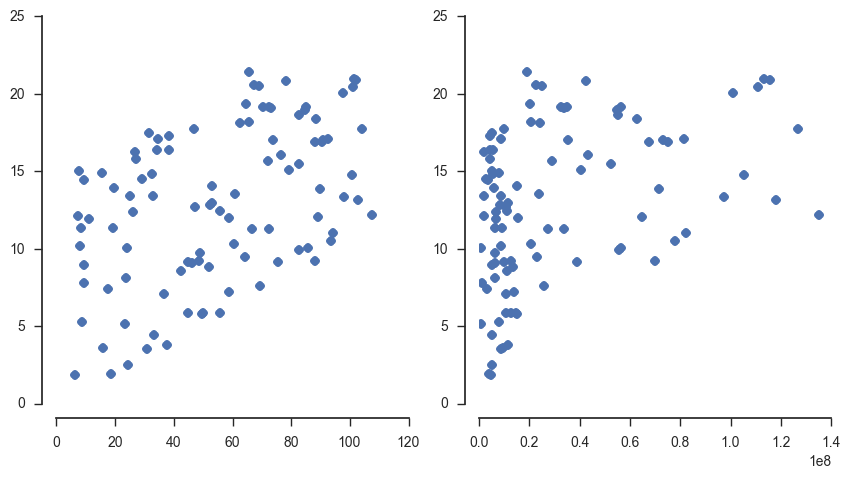

In [250]:
z = x*0.1+np.random.rand(100)*15
f = figure(figsize=(10,5))
s = subplot(121)
plot(x,z,'o')
sn.despine(offset=10)
s = subplot(122)
plot(y,z,'o')
sn.despine(offset=10)
rank_z = np.argsort(np.argsort(z))

In [254]:
# save to disk for comparison with matlab
np.savetxt('data.csv',np.vstack([rank_x,rank_y,rank_z]))

## 1 correlating residuals

In [255]:

"""
Partial Correlation in Python (clone of Matlab's partialcorr)

This uses the linear regression approach to compute the partial 
correlation (might be slow for a huge number of variables). The 
algorithm is detailed here:

    http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
the algorithm can be summarized as

    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
    2) calculate the residuals in Step #1
    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
    4) calculate the residuals in Step #3
    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 

    The result is the partial correlation between X and Y while controlling for the effect of Z


Date: Nov 2014
Author: Fabian Pedregosa-Izquierdo, f@bianp.net
Testing: Valentina Borghesani, valentinaborghesani@gmail.com
"""

import numpy as np
from scipy import stats, linalg

def partial_corr_residuals(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.


    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable


    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

## 2 inverting correlation matrix

In [270]:
def partial_corr_matrix_inversion(C,weights=None):
    if weights is None:
        P = np.mat(DescrStatsW(C).corrcoef).I
    else:
        P = np.mat(DescrStatsW(data=C,weights=weights).corrcoef).I
    n = P.shape[1]
    R = np.zeros((n,n))
    for i in range(n):
        R[i, i] = 1
        for j in range(i+1, n):
            corr = -P[i,j]/np.sqrt(P[i,i]*P[j,j])
            R[i,j] = R[j,i] = corr
    return R

## Comparing methods

In [271]:
print partial_corr_residuals(np.vstack([rank_x,rank_y,rank_z]).T)
print partial_corr_matrix_inversion(np.vstack([rank_x,rank_y,rank_z]).T)


[[ 1.          0.94690037  0.33407275]
 [ 0.94690037  1.         -0.09456543]
 [ 0.33407275 -0.09456543  1.        ]]
[[ 1.          0.9358466   0.31330642]
 [ 0.9358466   1.         -0.1611081 ]
 [ 0.31330642 -0.1611081   1.        ]]


This yields pretty similar results, but only the second one yields identical results to the matlab version

In [268]:
print 'regular correlation'
print DescrStatsW(data=np.vstack([rank_x,rank_y,rank_z]).T,weights=weights).corrcoef
print 'partial correlation'
print partial_corr_matrix_inversion(np.vstack([rank_x,rank_y,rank_z]).T,weights=None)
print 'weighted partial correlation'
print partial_corr_matrix_inversion(np.vstack([rank_x,rank_y,rank_z]).T,weights=weights)

regular correlation
[[ 1.          0.94093106  0.51778246]
 [ 0.94093106  1.          0.40715186]
 [ 0.51778246  0.40715186  1.        ]]
partial correlation
[[ 1.          0.9358466   0.31330642]
 [ 0.9358466   1.         -0.1611081 ]
 [ 0.31330642 -0.1611081   1.        ]]
weighted partial correlation
[[ 1.          0.93437836  0.43549008]
 [ 0.93437836  1.         -0.27632952]
 [ 0.43549008 -0.27632952  1.        ]]


The normal correlation method reports a relationship between x-z (0.9) and y-z (0.45), while
the partial correlation method reports a relationship between x-z (0.2), and not between y-z (0.08), which only existed because x and y were correlated.